# Play with light curve model in gammapy

Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time
from regions import CircleSkyRegion

import logging

log = logging.getLogger(__name__)

In [2]:
from gammapy.data import Observation
from gammapy.irf import load_cta_irfs
from gammapy.datasets import SpectrumDataset, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpDecayTemporalModel,
    SkyModel,
    LightCurveTemplateTemporalModel,
)
from gammapy.maps import MapAxis
from gammapy.estimators import LightCurveEstimator
from gammapy.makers import SpectrumDatasetMaker
from gammapy.modeling import Fit

Define a class for a Temporal model (in the first case `MyTemporalModel` the code is copied from gammapy)

In [3]:
# An exponential decay (just for test)
from gammapy.modeling.models import TemporalModel
from gammapy.modeling import Parameter
class MyTemporalModel(TemporalModel):
    """Temporal model with an exponential decay.
        ..math::
                F(t) = exp(t - t_ref)/t0
    Parameters
    ----------
    t0 : `~astropy.units.Quantity`
        Decay time scale
    t_ref: `~astropy.units.Quantity`
        The reference time in mjd
    """

    tag = "ExponentialDecayTemporalModel"

    t0 = Parameter("t0", "1 d", frozen=False)

    _t_ref_default = Time("2000-01-01")
    t_ref = Parameter("t_ref", _t_ref_default.mjd, unit="day", frozen=True)

    @staticmethod
    def evaluate(time, t0, t_ref):
        """Evaluate at given times"""
        return np.exp(-(time - t_ref) / t0)

    def integral(self, t_min, t_max):
        """Evaluate the integrated flux within the given time intervals
        Parameters
        ----------
        t_min: `~astropy.time.Time`
            Start times of observation
        t_max: `~astropy.time.Time`
            Stop times of observation
        Returns
        -------
        norm : float
            Integrated flux norm on the given time intervals
        """
        pars = self.parameters
        t0 = pars["t0"].quantity
        t_ref = Time(pars["t_ref"].quantity, format="mjd")
        value = self.evaluate(t_max, t0, t_ref) - self.evaluate(t_min, t0, t_ref)
        return -t0 * value / self.time_sum(t_min, t_max)

The class `PowerlawDecayTemporalModel` define a Power Law decay as temporal model

In [4]:
from gammapy.modeling.models import TemporalModel
from gammapy.modeling import Parameter
class PowerlawDecayTemporalModel(TemporalModel):
    """Temporal model with a power law decay.
        ..math::
                np.power(( (time - t_ref) / t0 ), index)
    Parameters
    ----------
    t0 : `~astropy.units.Quantity`
        Decay time scale
    t_ref: `~astropy.units.Quantity`
        The reference time in mjd
    index: `~astropy.units.Quantity`
        Power index 
    """

    tag = "PowerlawDecayTemporalModel"

    #t0 = Parameter("t0", "1 d", frozen=False)
    t0 = Parameter("t0", 1., unit="day", frozen=False)

    _t_ref_default = Time("2000-01-01")
    t_ref = Parameter("t_ref", _t_ref_default.mjd, unit="day", frozen=True)
    
    t_index = Parameter("t_index", -2.0)

    @staticmethod
    def evaluate(time, t0, t_ref, t_index):
        """Evaluate at given times"""
        return np.power(( (time - t_ref) / t0 ), t_index)

    def integral(self, t_min, t_max):
        """Evaluate the integrated flux within the given time intervals
        Parameters
        ----------
        t_min: `~astropy.time.Time`
            Start times of observation
        t_max: `~astropy.time.Time`
            Stop times of observation
        Returns
        -------
        norm : float
            Integrated flux norm on the given time intervals
        """
        pars = self.parameters
        t0 = pars["t0"].quantity
        t_index = pars["t_index"].quantity
        t_ref = Time(pars["t_ref"].quantity, format="mjd")
        dec1 = t_index+1.0
        value = self.evaluate(t_max, t0, t_ref, dec1) - self.evaluate(t_max, t0, t_ref, dec1)
        return (t0/dec1) * value / self.time_sum(t_min, t_max)

An instance of the `MyTemporalModel`class

In [5]:
gti_t0 = Time("2019-01-14 20:57:03")
temporal_model = MyTemporalModel(t0=6 * u.h, t_ref=gti_t0.mjd * u.d)

t_ref = gti_t0.mjd * u.d

t0 = t_ref
value0 = temporal_model.evaluate(t0, 1*u.h, t_ref)
print("Temporal model at time t = t_ref: {}".format(value0))

t1 = t0 + 1 * u.h
value1 = temporal_model.evaluate(t1, 1*u.h, t_ref)
print("After 1 hour: {}".format(value1))

Temporal model at time t = t_ref: 1.0
After 1 hour: 0.3678794411928557


Same exercise with `PowerlawDecayTemporalModel`

In [6]:
gti_t0 = Time("2019-01-14 20:57:03")
temporal_model = PowerlawDecayTemporalModel(t0=6 * u.day, t_ref=gti_t0.mjd * u.d, t_index=-1.6)

t_ref=gti_t0.mjd * u.d
t0 = 6 * u.d
t_index = -1.6

time = t_ref + 1 * u.d
value0 = temporal_model.evaluate(time, t0, t_ref, t_index)
print("Temporal model after 1 day: {}".format(value0))

time = t_ref + 10 * u.d
value0 = temporal_model.evaluate(time, t0, t_ref, t_index)
print("Temporal model after 10 day: {}".format(value0))

Temporal model after 1 day: 17.580936309501134
Temporal model after 10 day: 0.4416131536906999


In [7]:
# Getting the parameters from the object
gti_t0 = Time("2019-01-14 20:57:03")
temporal_model = PowerlawDecayTemporalModel(t0=6 * u.day, t_ref=gti_t0.mjd * u.d, t_index=-1.6)

pars = temporal_model.parameters

t0 = pars['t0'].quantity
t_ref = pars['t_ref'].quantity
t_index= pars['t_index'].quantity

time = t_ref + 1 * u.d
value0 = temporal_model.evaluate(time, t0, t_ref, t_index)
print("Temporal model after 1 day: {}".format(value0))

time = t_ref + 10 * u.d
value0 = temporal_model.evaluate(time, t0, t_ref, t_index)
print("Temporal model after 10 day: {}".format(value0))

Temporal model after 1 day: 17.580936309501134
Temporal model after 10 day: 0.4416131536906999


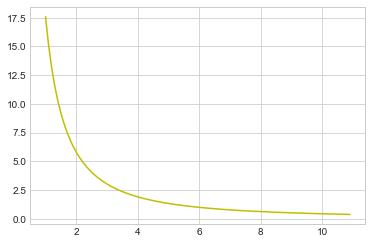

In [8]:
# Plot
plt.style.use('seaborn-whitegrid')

gti_t0 = Time("2019-01-14 20:57:03")
temporal_model = PowerlawDecayTemporalModel(t0=6 * u.day, t_ref=gti_t0.mjd * u.d, t_index=-1.6)

pars = temporal_model.parameters

t0 = pars['t0'].quantity
t_ref = pars['t_ref'].quantity
t_index= pars['t_index'].quantity

time = []
value = []

for i in range(100):
    t = t_ref + (i/10 + 1) * u.d
    time.append(t)
    v = temporal_model.evaluate(t, t0, t_ref, t_index)
    value.append(v)

    
x = [t.value-t_ref.value for t in time]
y = [v.value for v in value]

plt.plot(x, y,'y')